# Construction and meshing of fracture networks

In this tutorial, we will show:

1. How to define fractures and a fracture network in 2d and 3d.
2. How to construct a family of meshes that represent the domain, the fractures, and
their intersections.
3. Assembly of the grids into a `MixedDimensionalGrid` container that stores all grids,
and the geometric and topological relation between them.

Together, these are the first steps towards creating a simulation model for a
mixed-dimensional problem in fractured domains. For most simulation purposes, the
final mixed-dimensional grid is all that is needed.

Therefore, we start by showing a shortcut for obtaining a `MixedDimensionalGrid`
given a set of fractures, a domain, and mesh size parameters. All these will be
described in more detail below. We also mention that access to methods generating
mixed-dimensional grids for a small selection of geometries is available under
`pp.grids.standard_grids`.

## Meshing of fractures in 2d
Fracture networks in 2d are typically constructed by providing a list of
`LineFracture`s and a `Domain`.

Each `LineFracture` is constructed by giving the fracture's endpoint coordinates, e.g.,
as a `numpy.ndarray` of `shape = (2, 2)`. On the other hand, a `Domain` can be
defined by its bounding box in the case of box-shaped domains, or by defining the
polygon in the case of general domains.

Below, we define a fracture network with two fractures, which are fully embedded in a
rectangular domain. Finally, to create the fracture network, we use the function
`create_fracture_network()`.


In [1]:
import numpy as np
import porepy as pp

# Define the domain
bounding_box = {'xmin': -2, 'xmax': 3, 'ymin': -2, 'ymax': 3}
domain = pp.Domain(bounding_box)

# Define the list of line fractures
f_1 = pp.LineFracture(np.array([[0, 2], [0, 0]]))
f_2 = pp.LineFracture(np.array([[1, 1], [0, 1]]))
fractures = [f_1, f_2]

# Create the fracture network
network_2d = pp.create_fracture_network(fractures, domain)
print(network_2d)

Two-dimensional fracture network with 2 line fractures.
The domain is a rectangle with bounding box: {'xmin': -2, 'xmax': 3, 'ymin': -2, 'ymax': 3}.


Now that the fracture network has been constructed, we are ready for meshing. To do
so, we first declare the mesh arguments dictionary, containing the following keywords:

- `mesh_size_frac`: mesh size close to the fractures.
- `mesh_size_bound`: mesh size close to the boundary (can be seen as a far-field value).
- `mesh_size_min`: minimum mesh size (optional for 2d but mandatory for 3d).

For a more technical description of these parameters, see the section
__Interaction with Gmsh__.

Finally, we create the `MixedDimensionalGrid` via the `mesh` method.

In [2]:
# Set mesh arguments
mesh_args = {'mesh_size_frac': 0.3, 'mesh_size_bound': 1.0}

# Generate the mixed-dimensional grid
mdg = network_2d.mesh(mesh_args)

Visualizing the network, we see that the two fractures form a $Y$ (or $T$) type
intersection. The intersection point is identified during meshing and assigned a
zero-dimensional grid. The plot of `mdg` shows how the chosen mesh sizes result in
refinement towards the fractures.

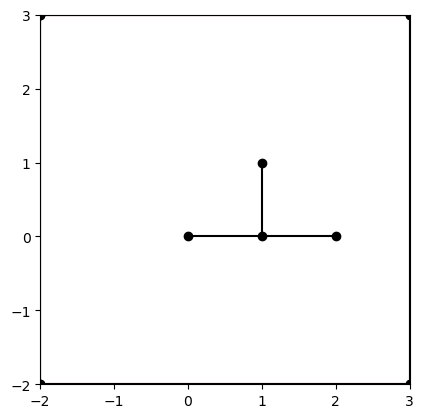

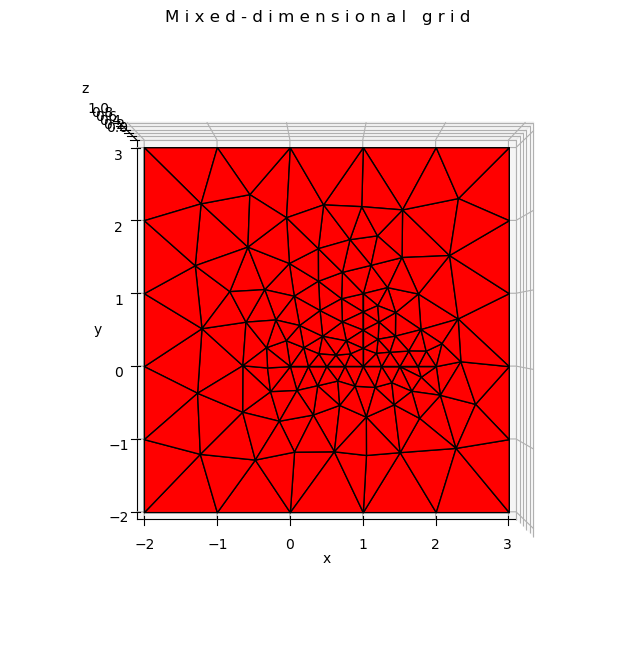

In [3]:
network_2d.plot()
pp.plot_grid(mdg, figsize=(8,8))

## Meshing of fractures in 3d

Fractures in 3d are polygons instead of lines. This makes computations of the geometry
considerably more difficult and requires further data structure to store the fractures.
Therefore, we define two `PlaneFracture` objects which are used for initialization of
the fracture network.

In [4]:
# We first define the domain. In this case, a cuboid:
bounding_box = {'xmin': -1, 'xmax': 3, 'ymin': -2, 'ymax': 3, 'zmin': -1.5, 'zmax': 3}
domain = pp.Domain(bounding_box=bounding_box)

# The fractures are specified by their vertices, which are 3 x num_points arrays
f_1 = pp.PlaneFracture(np.array([
        [0, 2, 2.5, 0],
        [0, 0, 1, 1],
        [0, 0, 1, 1]
    ]))

f_2 = pp.PlaneFracture(np.array([
        [1, 1, 1, 1],
        [-1, 2, 2, -1],
        [-1, -1, 2, 2]
    ]))

# Construct the 3d fracture network, following the same recipe as in 2d
network_3d = pp.create_fracture_network([f_1, f_2], domain)
print(network_3d)

Three-dimensional fracture network with 2 plane fractures.
The domain is a cuboid with bounding box: {'xmin': -1, 'xmax': 3, 'ymin': -2, 'ymax': 3, 'zmin': -1.5, 'zmax': 3}.


We now proceed to generate the mixed-dimensional grid. Note, that we now have to
provide a minimum mesh size as part of the mesh arguments:


In [5]:
mesh_args = {'mesh_size_frac': 0.5, 'mesh_size_min': 0.2, 'mesh_size_bound': 1.0}

# Generate the mixed-dimensional mesh
mdg = network_3d.mesh(mesh_args)

## Importing filters
Fracture networks in 2d (and 3d) can also be defined directly from files storing their
data, see `pp.fracture_importer` for the details.

## Visualizing the mixed-dimensional grid
The set of meshes in the `MixedDimensionalGrid` can be dumped to ParaView by simply
writing

In [6]:
pp.Exporter(mdg, 'mixed_dimensional_grid').write_vtu()

Again, some manipulations in ParaView show how the grids on fracture surfaces intersect
with each other and with the matrix grid.

<img src='mixed_dimensional_grid.png'  width=600>

# Advanced concepts and technical details

This section provides some more detail on the above demonstrated functionality and may
be skipped for users with limited interest in technicalities. We focus on the
technicalities related to 3d meshing; in 2d, meshing is relatively simple
(still difficult, but 3d is much worse).

Functionality for fractures and their intersections is provided in the subpackage
`porepy.fracs`.

## Elliptic fractures

In addition to the above method of defining fractures through their
vertices, we can also specify the fracture as an ellipsis, approximated as a polygon:

In [7]:
# Specify the fracture center
center = np.array([0.1, 0.3, 0.2])
# The minor and major axis
major_axis = 1.5
minor_axis = 0.5

# Rotate the major axis around the center.
# Note that the angle is measured in radians
major_axis_angle = np.pi/6

# So far, the fracture is located in the xy-plane. To define the incline, specify the
# strike angle, and the dip angle. Note that the dip rotation is carried out after
# the major_axis rotation (recall rotations are non-commutative).
strike_angle = -np.pi/3
dip_angle = -np.pi/3

# Finally, the number of points used to approximate the ellipsis. 
# This is the only optional parameter; if not specified, 16 points will be used.
num_pt = 12
f_3 = pp.create_elliptic_fracture(
    center,
    major_axis,
    minor_axis,
    major_axis_angle,
    strike_angle,
    dip_angle,
    num_points=num_pt
)

The fractures can be first joined into a fracture network via `create_fracture_network
()`:

In [8]:
network = pp.create_fracture_network(fractures=[f_1, f_2, f_3])

The `FractureNetwork3d` class is the base for analysis and manipulation of
three-dimensional fracture networks. The functionality is expanding on demand. For the
moment, the most interesting feature is the export of the fracture network to
ParaView (requires the vtk extension of python installed, see installation instruction):

In [9]:
network.to_file('fracture_network.vtu')

The resulting file can be opened in ParaView.

Note that we have not set a boundary for the fracture network, and effectively
for the domain. The boundary can be defined as a boudning box, and is imposed in the
following way:

In [10]:
# Define a domain based on its bounding box
bounding_box = {'xmin': -2, 'xmax': 3, 'ymin': -2, 'ymax': 3, 'zmin': -3, 'zmax': 3}
domain = pp.Domain(bounding_box)
network.impose_external_boundary(domain)

array([0, 1, 2])

Above, we defined the bounding box to not intersect with the fractures. If the domain
had been smaller, fractures that intersect a face of the box, by default (can be
overruled) are truncated so that they are confined within the bounding box.

## Meshing

Our aim is to create a computational mesh that _conforms_ to the fractures and their
intersections (1d lines, 0d points). For the actual grid construction, we rely on Gmsh.
However, Gmsh requires that the geometric constraints, that is the fractures, are
described as *non-intersecting* polygons. It only takes some thinking to understand why
the meshing software would not like to do this themselves; this is a highly challenging
task.

PorePy provides functionality for finding intersections between fractures, and splitting
them into non-intersecting polygons. Intersections are found by

In [11]:
network.split_intersections()

### Geometric tolerances and stability of meshing algorithm

A critical concept in meshing of fractured domains is the concept of geometric
tolerance: Since we are operating in finite precision aritmethics, two points may or
may not be considered equal (or similarly, two lines/planes may or may not intersect),
depending on how accurately we consider their representation. At least three concepts
come into play here

1. The accuracy of the numerical representation of the objects (accumulated effect of
finite precision rounding errors).
2. The accuracy in geological interpretation of fracture data. As an example, if the
fracture network originates from an interpretation of satellite images, differences
measured in centimeters should be treated with some caution.
3. The resolution of the computational grid: If points with a certain distance are
considered non-equal, this may also require that we resolve their difference in the
mesh. In addition, the mesh generator will use its own concept of geometric tolerance
for internal calculations.

In PorePy, we attempt to resolve these issues as follows: The `FractureNetwork3d`
(and the corresponding `FractureNetwork2d`) has an attribute `tol` that represents the
geometric tolerance used in the calculation of intersections and subsequent splitting
of the fractures. If meshing is done with Gmsh, the tolerances used in PorePy and Gmsh
are related. The approach works reasonably well, but for complex configurations of
fracture intersections, stability issues can arise.

### Interaction with Gmsh

Now, we want to create grids for the domain, as well as for fractures and fracture
intersections. This involves creating a config file for the mesh generator that contains
geometry description, including fracture planes and their intersections. The mesh is
then created by calling Gmsh. The resuling mesh information is read back to python,
and `Grid` objects representing the matrix, fractures, and fracture intersections are
created.

Gmsh is quite flexible in terms of letting the user set/guide the preferred mesh size
in different parts of the domain. PorePy tries to adjust to this adapting the specified
mesh size to the geometry. From the user side, two parameters must be specified:
`mesh_size_frac` gives the target mesh size in the absence of geometric constraints,
while `mesh_size_min` gives the minimal mesh size to be specified to Gmsh. Optionally,
the boundary may be assigned a separate mesh size through `mesh_size_bound`. What
actually happens with the mesh, that is, how Gmsh translates these preferred options
into a grid, is another matter. It may take some practice to get this to work properly.

If an acceptable mesh cannot be generated by tuning the three parameters
`mesh_size_frac`, `mesh_size_min` and `mesh_size_bound`, more fine-tuned mesh
generation can be achieved directly in Gmsh. A typical workflow would be first to
generate a gmsh configuration file using the function
`FractureNetwork.prepare_for_gmsh()`, then generate the mesh from Gmsh proper and store
it to a .msh file, and finally import the mesh using the functions from
`pp.fracture_importer` to obtain a MixedDimensionalGrid.

In [12]:
mesh_size_frac = 0.3
mesh_size_min = 0.2
mesh_args = {'mesh_size_frac': mesh_size_frac, 'mesh_size_min': mesh_size_min}

# With the mesh size parameters, we can simply ask the md-grid to mesh itself:
mdg = network.mesh(mesh_args)

# Show basic geometric information on the mixed-dimensional grid
print(mdg)


Mixed-dimensional grid. 
Maximum dimension present: 3 
Minimum dimension present: 1 
Size of highest dimensional grid: Cells: 29338. Nodes: 6146
In lower dimensions: 
3 grids of dimension 2, with in total 533 cells and 336 nodes. 
2 grids of dimension 1, with in total 8 cells and 10 nodes. 
Total number of interfaces: 6
3 interfaces between grids of dimension 3 and 2 with in total 1066 cells
4 interfaces between grids of dimension 2 and 1 with in total 32 cells



# What have we explored?

- Fractures in PorePy are defined as convex planes (in 3d) or lines (in 2d).
- A fracture network is a domain that contains a set of fractures. Therefrom, a
mixed-dimensional mesh can be constructed by invoking the `mesh()` method.
- The mesh size controlled by the parameters `mesh_size_frac`, `mesh_size_min`, and
`mesh_size_bound`.
- The actual mesh is constructed by the external package Gmsh.